In [1]:
import sys
sys.path.append('../..')

import attack
import data_loader as dl

In [2]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt
from shapely import Point

In [3]:
# Load data
gdf = gp.read_file('full_trip_HL_clustering.geojson').to_crs(4326)

In [4]:
# format clusering_HL columns as object
gdf['clustering_HL'] = gdf['clustering_HL'].astype('object')

In [5]:
gdf['START_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[0]))
gdf['END_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[-1]))

In [6]:
# plot trajectories of a random user and the corresponding clusters
user = random.choice(gdf['PERSON_ID'].unique())


# select random user
user_gdf = gdf[gdf['PERSON_ID'] == user]

# print nr of trajectories of user
print('Nr of trajectories of user: ', len(user_gdf))

# print nr of clusters of user
print('Nr of clusters of user: ', len(user_gdf['clustering_HL'].unique()))

# plot trajectories of user
user_gdf.explore(column='clustering_HL')


Nr of trajectories of user:  2
Nr of clusters of user:  1


/usr/local/lib/python3.8/dist-packages/geopandas/explore.py:362: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(gdf[column][~nan_idx], categories=categories)


In [ ]:
# plot start and end points of user
gp.GeoDataFrame(user_gdf[['START_POINT', 'END_POINT', 'clustering_HL']], geometry='START_POINT').explore(column='clustering_HL')

In [7]:
sp = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_START', 'START_POINT', 'clustering_HL']].copy()
ep = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_END', 'END_POINT', 'clustering_HL']].copy()


sp['lat'] = sp.START_POINT.apply(lambda x: x.y)
sp['lng'] = sp.START_POINT.apply(lambda x: x.x)
ep['lat'] = ep.END_POINT.apply(lambda x: x.y)
ep['lng'] = ep.END_POINT.apply(lambda x: x.x)

sp = sp.rename(columns={'TRIP_START': 'datetime'})
ep = ep.rename(columns={'TRIP_END': 'datetime'})

sp.drop('START_POINT', axis=1, inplace=True)
ep.drop('END_POINT', axis=1, inplace=True)

In [8]:
points = pd.concat([sp, ep])
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.lng, points.lat, crs='epsg:4326'))

In [10]:
from skmob.tessellation import tilers
import skmob
from shapely.geometry import Polygon


MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = 12.562133, 52.099718, 14.129426, 52.803108  # raw_points_gdf.geometry.total_bounds

TILE_DIAMETER_IN_METERS = (
    2000  # approximately. For h3 the most appropriate resolution is found
)
TILE_TYPE = "h3_tessellation"  # other option: "squared", "h3_tessellation"
####################################################################

base_shape = gp.GeoDataFrame(
    index=[0],
    crs=4326,
    geometry=[
        Polygon(
            zip(
                [MIN_LNG, MAX_LNG, MAX_LNG, MIN_LNG],
                [MIN_LAT, MIN_LAT, MAX_LAT, MAX_LAT],
            )
        )
    ],
)

tessellation = tilers.tiler.get(
    TILE_TYPE,
    base_shape=base_shape,
    meters=TILE_DIAMETER_IN_METERS,
).drop('H3_INDEX', axis=1)

/usr/local/lib/python3.8/dist-packages/skmob/tessellation/tilers.py:243: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


In [11]:
points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
points

,PERSON_ID,TRIP_ID,datetime,clustering_HL,lat,lng,geometry,tile_ID
0,17246,0,2022-10-21T14:59:24,21,52.530942,13.317532,POINT (13.31753 52.53094),638
1,17246,1,2022-10-21T16:07:38,21,52.538612,13.375194,POINT (13.37519 52.53861),656
2,17246,2,2022-10-21T19:16:16,21,52.538529,13.375381,POINT (13.37538 52.53853),656
3,17246,3,2022-10-21T20:41:59,73,52.531368,13.319161,POINT (13.31916 52.53137),638
4,16947,4,2022-10-23T09:32:44,45,52.528147,13.379241,POINT (13.37924 52.52815),1106
...,...,...,...,...,...,...,...,...
1370,16356,1403,2022-11-17T18:13:33,6,52.534717,13.198952,POINT (13.19895 52.53472),1266
1371,16356,1404,2022-11-17T18:35:06,6,52.531724,13.197715,POINT (13.19771 52.53172),1266
1372,16370,1405,2022-11-17T19:17:50,58,52.508464,13.390704,POINT (13.39070 52.50846),759
1373,16370,1406,2022-11-17T21:02:04,58,52.508462,13.391137,POINT (13.39114 52.50846),759


In [206]:
import math
points.groupby('tile_ID').clustering_HL #.nunique()#.plot.hist(bins=100)  #.apply(lambda x: math.log(x,2))

In [12]:
from tqdm import tqdm
tqdm.pandas()

def get_location_entropy(tile_id, mapped_points_gdf):
    assert isinstance(tile_id, str)
    t_trips = mapped_points_gdf.query("tile_ID == @tile_id")
    le = 0
    c_l = len(t_trips)
    for p in t_trips.clustering_HL:
        c_l_u = len(t_trips.query('clustering_HL == @p'))
        p_u_l =  c_l_u/ c_l
        le += p_u_l * math.log(p_u_l)
    return -le
        


In [402]:
points['location_entropy'] = points.tile_ID.progress_apply(lambda x: get_location_entropy(x, points))

100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [04:02<00:00, 11.34it/s]


In [406]:
points['location_entropy'] = points.location_entropy.apply(lambda x: 1 - (x - points.location_entropy.min())/(points.location_entropy.max() - points.location_entropy.min()))

<Axes: ylabel='Frequency'>

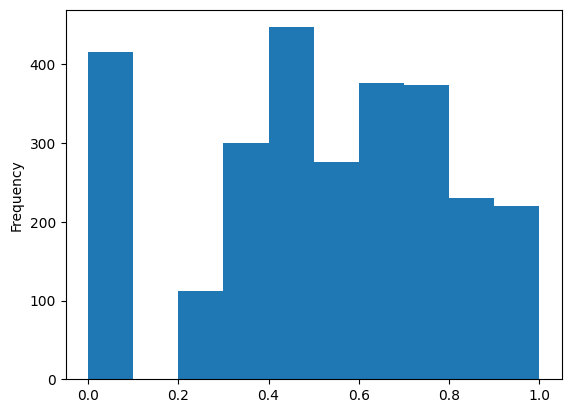

In [407]:
points.location_entropy.plot.hist()

In [408]:
loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL')
loc_frequencies

,clustering_HL,tile_ID,TRIP_ID
0,1,1096,1
1,1,118,8
2,1,1637,2
3,1,409,2
4,2,118,1
...,...,...,...
890,312,686,3
891,313,1384,1
892,313,686,1
893,314,1244,1


In [437]:
def get_location_similarity(cl_i, cl_j, loc_frequencies, points):
    overlap_tile_ids = set(loc_frequencies.query("clustering_HL == @cl_i").tile_ID).intersection(set(loc_frequencies.query("clustering_HL == @cl_j").tile_ID))
    
    loc_sim = 0
    for t in overlap_tile_ids:
        cl_i_count = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_i) & (loc_frequencies['tile_ID'] == t)].TRIP_ID.iloc[0]
        cl_j_count = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_j) & (loc_frequencies['tile_ID'] == t)].TRIP_ID.iloc[0]
        
        loc_sim += points.query("tile_ID == @t").location_entropy.iloc[0] * min(cl_i_count, cl_j_count)
    return loc_sim

In [438]:
M = np.zeros((loc_frequencies.clustering_HL.nunique(), loc_frequencies.clustering_HL.nunique()))

for i, cl_i in tqdm(enumerate(loc_frequencies.clustering_HL.unique()), total=loc_frequencies.clustering_HL.nunique()):
    
    for j, cl_j in enumerate(loc_frequencies.clustering_HL.unique()):
        if i == j:
            continue
            
        M[i, j] = get_location_similarity(cl_i, cl_j, loc_frequencies, points)

# Symmetrize
# M = M + M.T

# Set diagonal to 1
np.fill_diagonal(M, 1)
